# IMPORTANT 
Before you run this script, run the **Genome Download** script to download all the Coding sequences for each genomes. 
Then, run the Codon-Frequency extraction script **Calculate_Codon_Null_dist.py** as such  `./Calculate_Codon_Null_dist.py -i ../Genes/CDS -a`

In [2]:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import cluster
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import prettyplotlib as ppl
import scipy as sp
%matplotlib inline

# 1) Loading Sequences

In [ ]:
CodonsDict = {'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
               'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
               'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
               'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
               'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
               'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
               'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
               'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
               'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
               'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
               'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
               'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
               'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}

codon_list = sorted(CodonsDict.keys())

path = '../Genes/CDS'
dbs = os.listdir(path)
dbs = [i for i in dbs if 'CDS.fasta' in i and not 'highSet' in i]
print dbs
f = open(os.path.join('../Genes/','LOTUS_Seqeuences_2.gb'))
handle = SeqIO.parse(f, 'gb')
LOTUS = {}
for i in handle:
    LOTUS[i.annotations['organism']] = i
f = open(os.path.join('../Genes/','SGNH_Seqeuences.gb'))
handle = SeqIO.parse(f, 'gb')
SGNH = {}
for i in handle:
    SGNH[i.annotations['organism']] = i

# 2) Define Functions

In [5]:
def _count_codons_freq(seq):
    # make the codon dictionary local
    codon_count = CodonsDict.copy()
    # Make sure the sequence starts with a start codon and is a multiple of 3
    tot = 0.0
    if len(seq.seq) % 3 == 0:
        # make sure the sequence is lower case
        if str(seq.seq).islower():
            dna_sequence = str(seq.seq).upper()
        else:
            dna_sequence = str(seq.seq)
        for i in range(0, len(dna_sequence), 3):
            codon = dna_sequence[i:i + 3]
            if codon in codon_count:
                tot += 1.0
                codon_count[codon] += 1
            else:
                print "illegal codon %s in gene: %s" % (codon, seq.id)
        if tot:
            for c in codon_count:
                codon_count[c] = codon_count[c] / tot
            return codon_count
        else:
            return None
    else:
        print "invalid CDS"
        
def make_codon_list(cod):
    tmp = []
    for c in sorted(CodonsDict.keys()):
        tmp.append(cod[c])
    return tmp

def GC3(seq):
    gc3 = 0.0
    at3 = 0.0
    if len(seq.seq) % 3 == 0:
        skip = False
        alphabet = [i for i in "BDEFHIJKLMNOPQRSUVWXYZ"]
        for let in alphabet:
            if let in str(seq.seq):
                skip = True
        if not skip:
            for i in range(0, len(seq), 3):
                if seq[i:i+3][2] in ['G','C']:
                    gc3 += 1
                else:
                    at3 += 1
            return at3/(at3+gc3), gc3/(at3+gc3)
    return None, None

def wobble(seq):
    g3 = 0.0
    a3 = 0.0
    c3 = 0.0
    t3 = 0.0
    if len(seq.seq) % 3 == 0:
        skip = False
        alphabet = [i for i in "BDEFHIJKLMNOPQRSUVWXYZ"]
        for let in alphabet:
            if let in str(seq.seq):
                skip = True
        if not skip:
            for i in range(0, len(seq), 3):
                if seq[i:i+3][2] == 'G':
                    g3 += 1
                elif seq[i:i+3][2] == 'C':
                    c3 += 1
                elif seq[i:i+3][2] == 'A':
                    a3 += 1
                elif seq[i:i+3][2] == 'T':
                    t3 += 1
            tot = a3 + g3 + c3 + t3
            return a3/tot, t3/tot, g3/tot, c3/tot
    return None, None, None, None

def Z_score(x, dist):
    #Z = x-mu/sigma
    mu = np.mean(dist)
    sigma = np.std(dist)
    z = (x-mu)/sigma
    return z

def z_to_p(z,output="F"):
    p=0.5*(1+sp.special.erf(z/np.sqrt(2)))
    if output=="T":
        print "###########################################"
        print "#       Convert Z score to p-value        #"
        print "###########################################"
        print "                          Z= "+str(z)
        print " Left-tailed p-value P(z<Z)= "+str(p)
        print "Right-tailed p-value P(z>Z)= "+str(1-p)
        print "Two tailed p-value P(|z|>Z)= "+str(2*(1-p))
        print ""
    else:
        return 2*(1-p)

# 3) Calculate codon frequencies accross the datasets

## Calculate Osk GC3/AT3

In [9]:
osk = []
for k in LOTUS:
    la, lg = GC3(LOTUS[k])
    sa, sg = GC3(SGNH[k])
    osk.append([k, 'LOTUS', 'AT3', la])
    osk.append([k, 'LOTUS', 'GC3', lg])
    osk.append([k, 'SGNH', 'AT3', sa])
    osk.append([k, 'SGNH', 'GC3', sg])

osk = pd.DataFrame(osk, columns=['Organism', 'Domain','Codon','Frequency'] )

## Calculate A3, G3, C3, T3 usage

In [10]:
osk3 = []
for k in LOTUS:
    la, lt, lc, lg = wobble(LOTUS[k])
    sa, st, sc, sg = wobble(SGNH[k])
    osk3.append([k, 'LOTUS', 'A3', la])
    osk3.append([k, 'LOTUS', 'T3', lt])
    osk3.append([k, 'LOTUS', 'C3', lc])
    osk3.append([k, 'LOTUS', 'G3', lg])
    osk3.append([k, 'SGNH', 'A3', sa])
    osk3.append([k, 'SGNH', 'T3', st])
    osk3.append([k, 'SGNH', 'C3', sc])
    osk3.append([k, 'SGNH', 'G3', sg])

osk3 = pd.DataFrame(osk3, columns=['Organism', 'Domain','Codon','Frequency'] )

## Calculate Codon Usage Datasets 

In [11]:
data = []
for db in dbs:
    orga = db.split('.')[0].replace('_',' ')
    handle = SeqIO.parse(os.path.join(path,db),'fasta')
    for seq in handle:
        at, gc = GC3(seq)
        if at:
            data.append([orga,at,gc])
data= pd.DataFrame(data, columns=['Organism','AT3','GC3'])

In [12]:
data3 = []
for db in dbs:
    orga = db.split('.')[0].replace('_',' ')
    handle = SeqIO.parse(os.path.join(path,db),'fasta')
    for seq in handle:
        a,t,c,g = wobble(seq)
        if a:
            data3.append([orga,'A3',a])
            data3.append([orga,'T3',t])
            data3.append([orga,'C3',c])
            data3.append([orga,'G3',g])
data3= pd.DataFrame(data3, columns=['Organism','Codon','Frequency'])

In [13]:
data2= []
for i in range(len(data)):
    o = data['Organism'][i]
    a = data['AT3'][i]
    g = data['GC3'][i]
    data2.append([o,'AT3',a])
    data2.append([o,'GC3',g])
data2 = pd.DataFrame(data2, columns=['Organism','Codon','Frequency'])

# 4) Creating the Intra-Gene null distribution dataset

In [16]:
path = '../Genes/CDS'
dbs_cds = os.listdir(path)
dbs_cds = [i for i in dbs_cds if 'CDS' in i and 'highSet' not in i]
genomes = {}
null = {}
for genome in dbs_cds:
    print genome
    print os.path.join(path, genome)
    orga = genome.split('.')[0].replace('_',' ')
    handle = SeqIO.parse(os.path.join(path, genome),'fasta')
    genomes[orga] = []
    null[orga] = []
    for seq in handle:
#         print len(seq) % 3 
        if len(seq) % 3 == 0 and str(seq.seq[0:3]) == 'ATG':
            skip = False
            alphabet = [i for i in "BDEFHIJKLMNOPQRSUVWXYZ"]
            for let in alphabet:
                if let in str(seq.seq):
                    skip = True
            if not skip:
                genomes[orga].append(seq)
                l = len(seq)
                if l > 702:
                    s = 1
                    while s%3 != 0:
                        s = np.random.randint(351, l-351)
                    null[orga].append([seq[:s], seq[s:]])

Polistes_canadensis.CDS.fasta
../Genes/CDS/Polistes_canadensis.CDS.fasta
Culex_quinquefasciatus.CDS.fasta
../Genes/CDS/Culex_quinquefasciatus.CDS.fasta
Copidosoma_floridanum.CDS.fasta
../Genes/CDS/Copidosoma_floridanum.CDS.fasta
Fopius_arisanus.CDS.fasta
../Genes/CDS/Fopius_arisanus.CDS.fasta
Stomoxys_calcitrans.CDS.fasta
../Genes/CDS/Stomoxys_calcitrans.CDS.fasta
Drosophila_virilis.CDS.fasta
../Genes/CDS/Drosophila_virilis.CDS.fasta
Orussus_abietinus.CDS.fasta
../Genes/CDS/Orussus_abietinus.CDS.fasta
Musca_domestica.CDS.fasta
../Genes/CDS/Musca_domestica.CDS.fasta
Bactrocera_dorsalis.CDS.fasta
../Genes/CDS/Bactrocera_dorsalis.CDS.fasta
Harpegnathos_saltator.CDS.fasta
../Genes/CDS/Harpegnathos_saltator.CDS.fasta
Neodiprion_lecontei.CDS.fasta
../Genes/CDS/Neodiprion_lecontei.CDS.fasta
Ceratitis_capitata.CDS.fasta
../Genes/CDS/Ceratitis_capitata.CDS.fasta
Acromyrmex_echinatior.CDS.fasta
../Genes/CDS/Acromyrmex_echinatior.CDS.fasta
Nasonia_vitripennis.CDS.fasta
../Genes/CDS/Nasonia_vitrip

In [17]:
null_at3gc3 = []
null_codon3 = []
for orga in null:
    for gene in null[orga]:
        name = gene[0].name
        a0,t0,c0,g0 = wobble(gene[0])
        a1,t1,c1,g1 = wobble(gene[1])
        at0, gc0 = GC3(gene[0])
        at1, gc1 = GC3(gene[1])
        null_at3gc3.append([orga, name, 'D0', 'A3', a0])
        null_at3gc3.append([orga, name, 'D0', 'T3', t0])
        null_at3gc3.append([orga, name, 'D0', 'C3', c0])
        null_at3gc3.append([orga, name, 'D0', 'G3', g0])
        null_at3gc3.append([orga, name, 'D1', 'A3', a1])
        null_at3gc3.append([orga, name, 'D1', 'T3', t1])
        null_at3gc3.append([orga, name, 'D1', 'C3', c1])
        null_at3gc3.append([orga, name, 'D1', 'G3', g1])
        null_codon3.append([orga, name, 'D0', 'AT3', at0])
        null_codon3.append([orga, name, 'D0', 'GC3', at0])
        null_codon3.append([orga, name, 'D1', 'AT3', at1])
        null_codon3.append([orga, name, 'D1', 'GC3', gc1])

In [18]:
null_at3gc3 = pd.DataFrame(null_at3gc3, columns=['Organism','Gene','Domain','Codon','Frequency'])
null_codon3 = pd.DataFrame(null_codon3, columns=['Organism','Gene','Domain','Codon','Frequency'])

In [19]:
null_at3gc3.to_csv('null_at3gc3.csv', index=False)
null_codon3.to_csv('null_codon3.csv', index=False)

In [20]:
null_at3gc3_Z_score = np.zeros(len(null_at3gc3))
null_codon_Z_score = np.zeros(len(null_codon3))
for orga in LOTUS:
    for codon in ['A3', 'T3', 'C3','G3']:
        fre = null_at3gc3[(null_at3gc3['Organism'] == orga) & (null_at3gc3['Codon'] == codon)]['Frequency']
        index = fre.index
        fre = fre.values
        dist = data3[(data3['Organism'] == orga) & (data3['Codon'] == codon)]['Frequency'].values
        z = Z_score(fre, dist)
        for i in range(len(index)):
            null_at3gc3_Z_score[index[i]] = z[i] 
    for codon in ['AT3','GC3']:
        fre = null_codon3[(null_codon3['Organism'] == orga) & (null_codon3['Codon'] == codon)]['Frequency']
        index = fre.index
        fre = fre.values
        z = Z_score(fre, data2[(data2['Organism'] == orga) & (data2['Codon'] == codon)]['Frequency'].values)
        for i in range(len(index)):
            null_codon_Z_score[index[i]] = z[i] 

In [21]:
null_at3gc3['Z_score'] = pd.Series(null_at3gc3_Z_score, index=null_at3gc3.index)
null_codon3['Z_score'] = pd.Series(null_codon_Z_score, index=null_codon3.index)

# 5) Analysis of the A3/T3/G3/C3 content between OSK and LOTUS vs genome Intra-Gene distribution

In [22]:
res = []
res2 = []
for orga in LOTUS:
    for codon in ['A3','T3','C3','G3']:
        a = data3[(data3['Organism'] == orga) & (data3['Codon'] == codon)]['Frequency'].values
        b = osk3[(osk3['Organism'] == orga) & (osk3['Codon'] == codon) & (osk3['Domain'] == 'LOTUS')]['Frequency'].values
        c = osk3[(osk3['Organism'] == orga) & (osk3['Codon'] == codon) & (osk3['Domain'] == 'SGNH')]['Frequency'].values
        Z = Z_score(np.array([b[0],c[0]]), a)
        p_values = sp.stats.norm.sf(abs(Z))*2
        res.append([orga, codon, 'LOTUS' ,Z[0], p_values[0]])
        res.append([orga, codon, 'SGNH' ,Z[1], p_values[1]])
    for codon in ['AT3','GC3']:
        a = data2[(data2['Organism'] == orga) & (data2['Codon'] == codon)]['Frequency'].values
        b = osk[(osk['Organism'] == orga) & (osk['Codon'] == codon) & (osk['Domain'] == 'LOTUS')]['Frequency'].values
        c = osk[(osk['Organism'] == orga) & (osk['Codon'] == codon) & (osk['Domain'] == 'SGNH')]['Frequency'].values
        Z = Z_score(np.array([b[0],c[0]]), a)
        p_values = sp.stats.norm.sf(abs(Z))*2
        res2.append([orga, codon, 'LOTUS' ,Z[0], p_values[0]])
        res2.append([orga, codon, 'SGNH' ,Z[1], p_values[1]])
signi_3_df = pd.DataFrame(res, columns=['Organism','Codon','Domain','Z_score','p-value'])
signi_GC3_df = pd.DataFrame(res2, columns=['Organism','Codon','Domain','Z_score','p-value'])

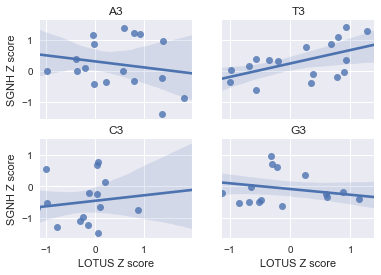

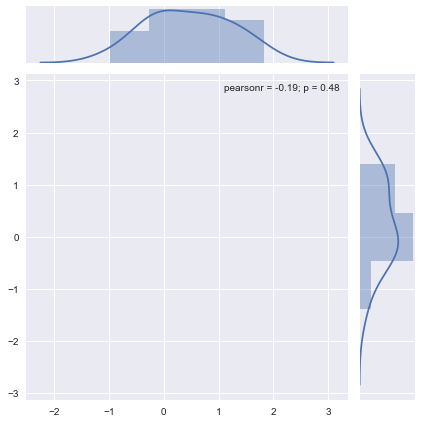

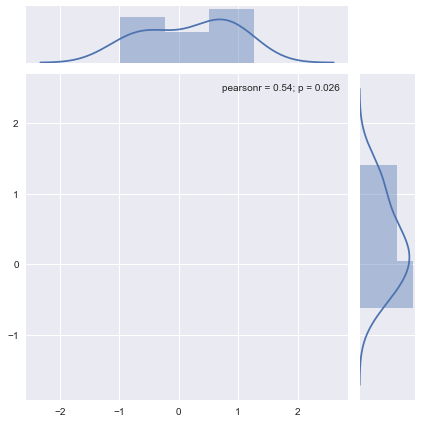

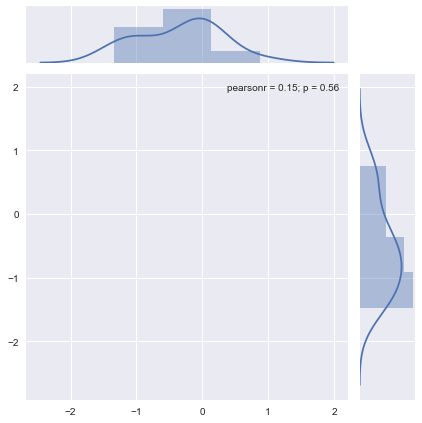

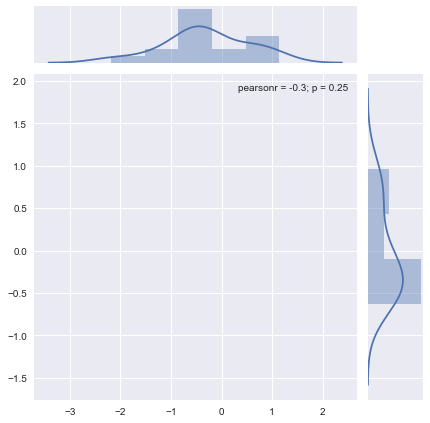

In [23]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
codons = ['A3','T3','C3','G3']
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    codon = codons[i]
    ax = axes[i]
    x = signi_3_df[(signi_3_df['Domain']=='LOTUS')  & (signi_3_df['Codon']==codon)]['Z_score'].values
    y = signi_3_df[(signi_3_df['Domain']=='SGNH')  & (signi_3_df['Codon']==codon)]['Z_score'].values
    sns.jointplot(x,y,ax=ax,kind="reg")
    ax.set_title(codon)
    if i in [2,3]:
        ax.set_xlabel('LOTUS Z score')
    if i in [0,2]:
        ax.set_ylabel('SGNH Z score')
f.savefig('Oskar_Wobble_Codon_Use.png',dpi=600)

## Plotting Intra-Gene Wobble position Codon usage correlation analysis

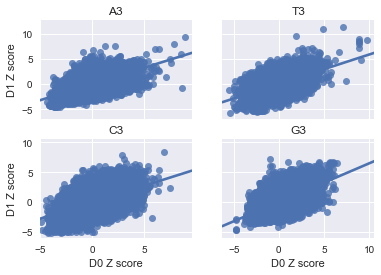

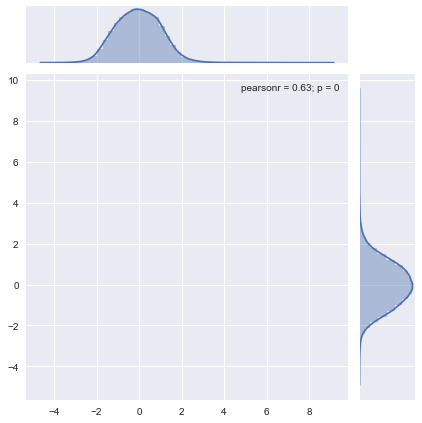

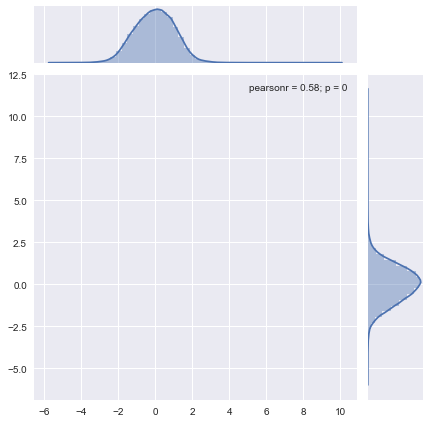

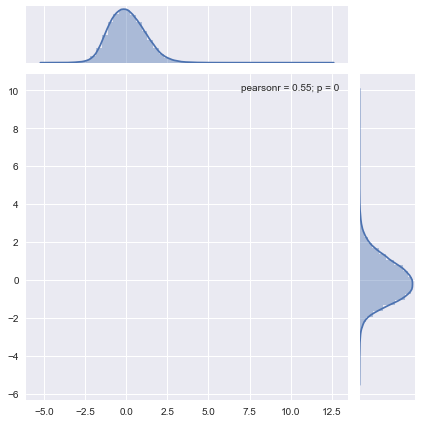

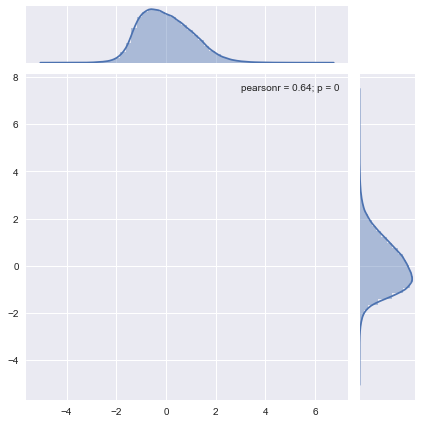

In [24]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
codons = ['A3','T3','C3','G3']
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    codon = codons[i]
    ax = axes[i]
    x = null_at3gc3[(null_at3gc3['Domain'] == 'D0') & (null_at3gc3['Codon'] == codon)]['Z_score'].values
    y = null_at3gc3[(null_at3gc3['Domain'] == 'D1') & (null_at3gc3['Codon'] == codon)]['Z_score'].values
    sns.jointplot(x,y,ax=ax,kind="reg")
    ax.set_title(codon)
    if i in [2,3]:
        ax.set_xlabel('D0 Z score')
    if i in [0,2]:
        ax.set_ylabel('D1 Z score')
f.savefig('Intra-Gene_Wobble_Position_Codon_Use.png',dpi=600)

In [25]:
pearson = []
codons = ['A3','T3','C3','G3']
for i in range(4):
    codon = codons[i]
    x = signi_3_df[(signi_3_df['Domain']=='LOTUS')  & (signi_3_df['Codon']==codon)]['Z_score'].values
    y = signi_3_df[(signi_3_df['Domain']=='SGNH')  & (signi_3_df['Codon']==codon)]['Z_score'].values
    r,p = sp.stats.pearsonr(x,y)
    pearson.append(['Oskar',codon, r**2, p])
    x = null_at3gc3[(null_at3gc3['Domain'] == 'D0') & (null_at3gc3['Codon'] == codon)]['Z_score'].values
    y = null_at3gc3[(null_at3gc3['Domain'] == 'D1') & (null_at3gc3['Codon'] == codon)]['Z_score'].values
    r,p = sp.stats.pearsonr(x,y)
    pearson.append(['Intra-Gene',codon, r**2, p])
pearson = pd.DataFrame(pearson, columns=['Distribution','Codon','r-value','p-value'])
pearson

,Distribution,Codon,r-value,p-value
0,Oskar,A3,0.034479,0.475517
1,Intra-Gene,A3,0.399446,0.000000
2,Oskar,T3,0.288744,0.026117
3,Intra-Gene,T3,0.333851,0.000000
4,Oskar,C3,0.023143,0.559977
5,Intra-Gene,C3,0.299565,0.000000
6,Oskar,G3,0.088341,0.246639
7,Intra-Gene,G3,0.409425,0.000000


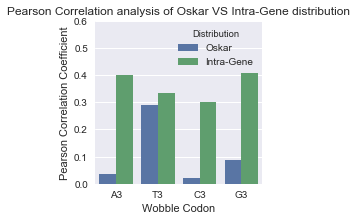

In [26]:
f = plt.figure(figsize=(3,3))
sns.barplot(data=pearson, x='Codon', y='r-value', hue='Distribution')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Wobble Codon')
plt.title('Pearson Correlation analysis of Oskar VS Intra-Gene distribution')
plt.ylim(0,0.6)
f.savefig('wobble_Pearson_correlation.png',dpi=600)
f.savefig('wobble_Pearson_correlation.pdf')

# 6) Analysis of the AT3/GC3 content between OSK and LOTUS vs genome Intra-Gene distribution

## Plotting GC3 content Intra Gene distribution and OSK vs LOTUS

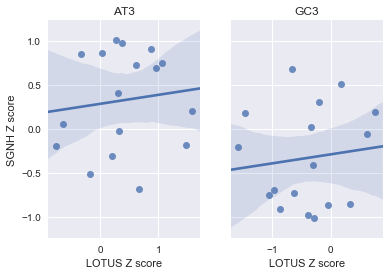

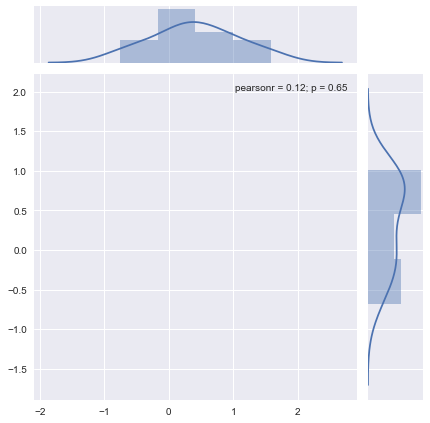

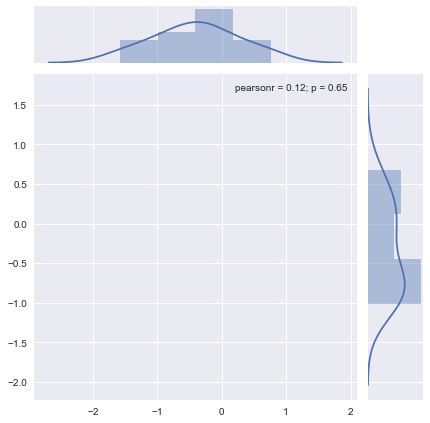

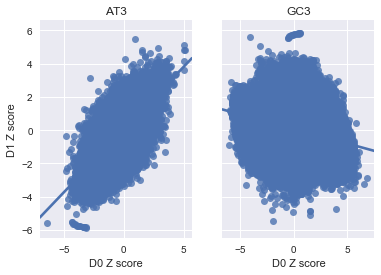

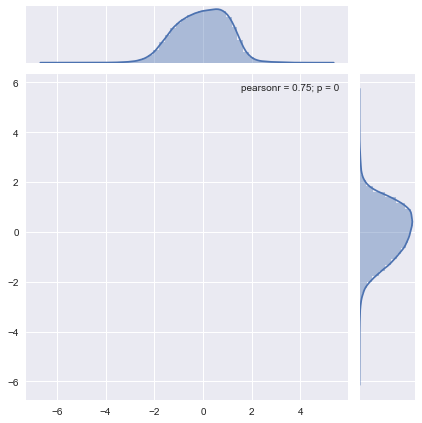

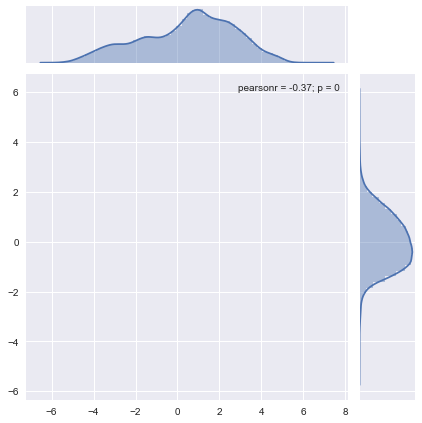

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
codons = ['AT3','GC3']
axes = [ax1, ax2]
for i in range(2):
    codon = codons[i]
    ax = axes[i]
    x = signi_GC3_df[(signi_GC3_df['Domain']=='LOTUS')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    y = signi_GC3_df[(signi_GC3_df['Domain']=='SGNH')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    sns.jointplot(x,y,ax=ax,kind="reg")
    ax.set_title(codon)
    if i in [1,0]:
        ax.set_xlabel('LOTUS Z score')
    if i in [0,2]:
        ax.set_ylabel('SGNH Z score')
f.savefig('Oskar_GC3_Codon_Use.png',dpi=600)

f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
codons = ['AT3','GC3']
axes = [ax1, ax2]
for i in range(2):
    codon = codons[i]
    ax = axes[i]
    x = null_codon3[(null_codon3['Domain'] == 'D0') & (null_codon3['Codon'] == codon)]['Z_score'].values
    y = null_codon3[(null_codon3['Domain'] == 'D1') & (null_codon3['Codon'] == codon)]['Z_score'].values
    sns.jointplot(x,y, ax=ax, kind="reg")
    ax.set_title(codon)
    if i in [1,0]:
        ax.set_xlabel('D0 Z score')
    if i in [0,2]:
        ax.set_ylabel('D1 Z score')
f.savefig('Intra-Gene_GC3_Codon_Use.png', dpi=600)

## Pearson correlation calculations

In [28]:
pearson = []
codons = ['AT3','GC3']
for i in range(2):
    codon = codons[i]
    x = signi_GC3_df[(signi_GC3_df['Domain']=='LOTUS')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    y = signi_GC3_df[(signi_GC3_df['Domain']=='SGNH')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    r,p = sp.stats.pearsonr(x,y)
    pearson.append(['Oskar',codon, r**2, p])
    x = null_codon3[(null_codon3['Domain'] == 'D0') & (null_codon3['Codon'] == codon)]['Z_score'].values
    y = null_codon3[(null_codon3['Domain'] == 'D1') & (null_codon3['Codon'] == codon)]['Z_score'].values
    r,p = sp.stats.pearsonr(x,y)
    pearson.append(['Intra-Gene',codon, r**2, p])
pearson = pd.DataFrame(pearson, columns=['Distribution','Codon','r-value','p-value'])
pearson

,Distribution,Codon,r-value,p-value
0,Oskar,AT3,0.014441,0.645947
1,Intra-Gene,AT3,0.560090,0.000000
2,Oskar,GC3,0.014441,0.645947
3,Intra-Gene,GC3,0.138656,0.000000


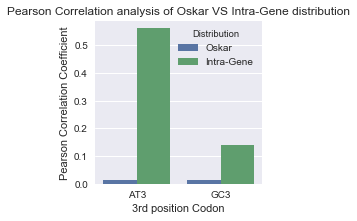

In [29]:
f = plt.figure(figsize=(3,3))
sns.barplot(data=pearson, x='Codon', y='r-value', hue='Distribution')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('3rd position Codon')
plt.title('Pearson Correlation analysis of Oskar VS Intra-Gene distribution')
f.savefig('GC3_Pearson_correlation.png',dpi=600)
f.savefig('GC3_Pearson_correlation.pdf')

# 7) Analysis of the residuals of the linear regression of genome AT3/GC3 content

In [30]:
codons = ['AT3','GC3']
for i in range(2):
    codon = codons[i]
    print codon
    x = null_codon3[(null_codon3['Domain'] == 'D0')  & (null_codon3['Codon'] == codon)]['Z_score'].values
    y = null_codon3[(null_codon3['Domain'] == 'D1')  & (null_codon3['Codon'] == codon)]['Z_score'].values
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
    print slope, intercept, r_value, p_value, std_err
    print sp.stats.pearsonr(x,y)
    x = signi_GC3_df[(signi_GC3_df['Domain']=='LOTUS')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    y = signi_GC3_df[(signi_GC3_df['Domain']=='SGNH')  & (signi_GC3_df['Codon']==codon)]['Z_score'].values
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
    print slope, intercept, r_value, p_value, std_err
    print sp.stats.pearsonr(x,y)

AT3
0.755897593384 0.0343073459903 0.748391633138 0.0 0.00131951421716
(0.74839163313807566, 0.0)
0.102312872675 0.287059236555 0.120168756119 0.645947157158 0.218240074415
(0.12016875611911097, 0.6459471571575659)
GC3
-0.176629854442 0.0820762974267 -0.372365010867 0.0 0.000867125129681
(-0.37236501086717982, 0.0)
0.102312872675 -0.287059236555 0.120168756119 0.645947157158 0.218240074415
(0.1201687561191101, 0.64594715715756834)


26289
('Coefficients: \n', array([[ 0.74664179]]))
Residual sum of squares: 0.56
Residual sum of squares Osk: 0.70
Variance score: 0.52


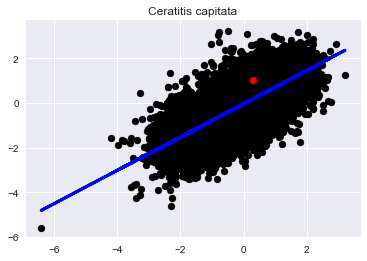

14097
('Coefficients: \n', array([[ 0.75418856]]))
Residual sum of squares: 0.37
Residual sum of squares Osk: 0.01
Variance score: 0.67


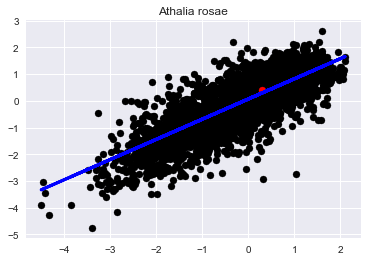

14819
('Coefficients: \n', array([[ 0.75170468]]))
Residual sum of squares: 0.43
Residual sum of squares Osk: 1.22
Variance score: 0.60


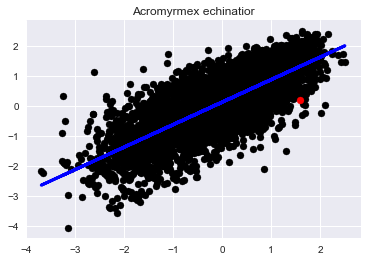

10938
('Coefficients: \n', array([[ 0.84723207]]))
Residual sum of squares: 0.35
Residual sum of squares Osk: 0.39
Variance score: 0.70


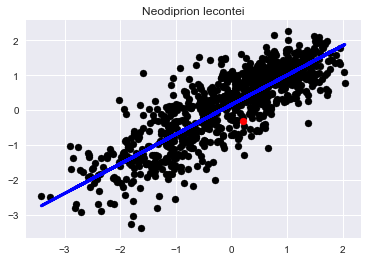

12058
('Coefficients: \n', array([[ 0.76853622]]))
Residual sum of squares: 0.55
Residual sum of squares Osk: 0.08
Variance score: 0.52


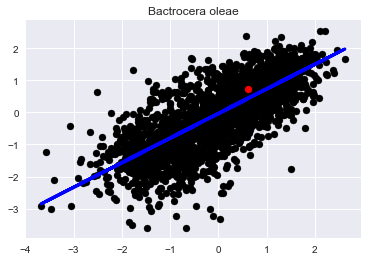

15594
('Coefficients: \n', array([[ 0.65536447]]))
Residual sum of squares: 0.80
Residual sum of squares Osk: 0.00
Variance score: 0.36


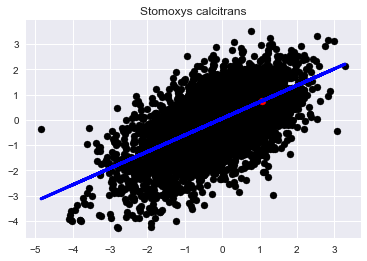

17620
('Coefficients: \n', array([[ 0.70248895]]))
Residual sum of squares: 0.69
Residual sum of squares Osk: 0.52
Variance score: 0.43


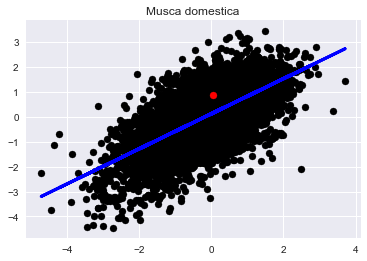

12097
('Coefficients: \n', array([[ 0.85649414]]))
Residual sum of squares: 0.31
Residual sum of squares Osk: 0.25
Variance score: 0.73


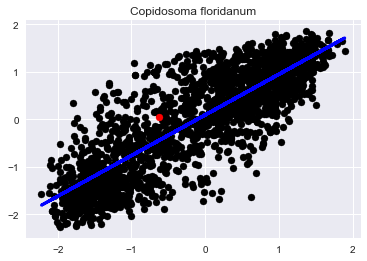

14763
('Coefficients: \n', array([[ 0.75499487]]))
Residual sum of squares: 0.48
Residual sum of squares Osk: 0.16
Variance score: 0.66


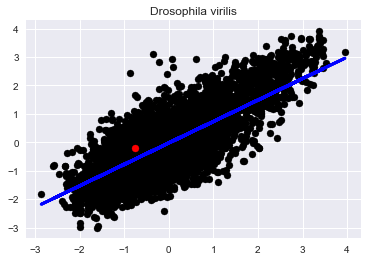

12297
('Coefficients: \n', array([[ 0.70262751]]))
Residual sum of squares: 0.51
Residual sum of squares Osk: 0.60
Variance score: 0.46


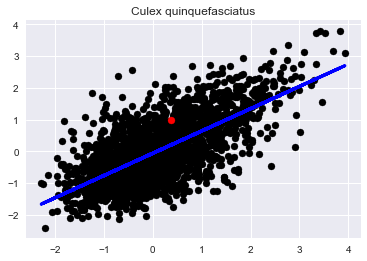

14143
('Coefficients: \n', array([[ 0.78473781]]))
Residual sum of squares: 0.34
Residual sum of squares Osk: 1.81
Variance score: 0.70


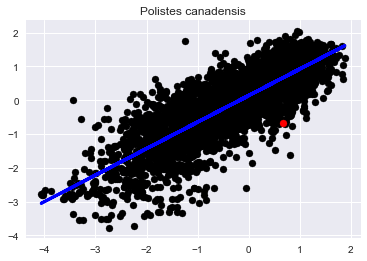

12923
('Coefficients: \n', array([[ 0.79054597]]))
Residual sum of squares: 0.40
Residual sum of squares Osk: 0.00
Variance score: 0.64


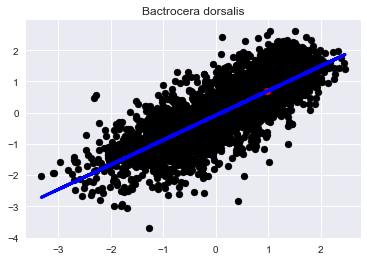

21388
('Coefficients: \n', array([[ 0.74256052]]))
Residual sum of squares: 0.50
Residual sum of squares Osk: 1.08
Variance score: 0.54


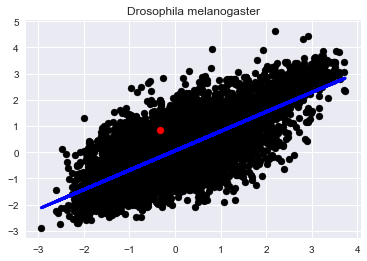

13031
('Coefficients: \n', array([[ 0.8378577]]))
Residual sum of squares: 0.30
Residual sum of squares Osk: 0.05
Variance score: 0.71


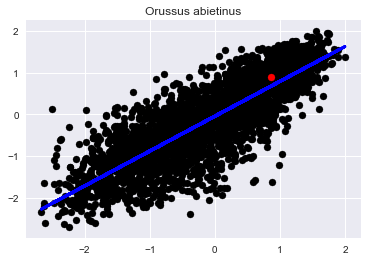

17142
('Coefficients: \n', array([[ 0.84312263]]))
Residual sum of squares: 0.31
Residual sum of squares Osk: 0.19
Variance score: 0.70


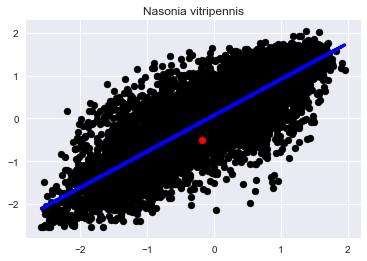

14934
('Coefficients: \n', array([[ 0.76928304]]))
Residual sum of squares: 0.29
Residual sum of squares Osk: 0.03
Variance score: 0.72


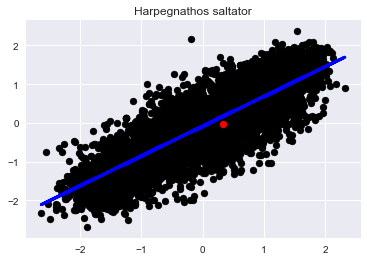

13622
('Coefficients: \n', array([[ 0.58333552]]))
Residual sum of squares: 0.70
Residual sum of squares Osk: 1.30
Variance score: 0.28


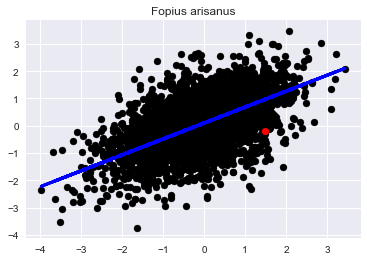

In [31]:
codon = 'AT3'
residuals= []
for orga in LOTUS:
    # Split the data into training/testing sets
    X = null_codon3[(null_codon3['Domain'] == 'D0') & (null_codon3['Organism'] == orga) & (null_codon3['Codon'] == codon)]['Z_score'].values
    print len(X)
    X_train = np.array([X[:10000]]).T
    X_test = np.array([X[10000:]]).T
    X_osk = np.array([signi_GC3_df[(signi_GC3_df['Domain']=='LOTUS') & (signi_GC3_df['Organism']== orga) & (signi_GC3_df['Codon']==codon)]['Z_score'].values]).T
    # Split the targets into training/testing sets
    Y = null_codon3[(null_codon3['Domain'] == 'D1') & (null_codon3['Organism'] == orga) & (null_codon3['Codon'] == codon)]['Z_score'].values
    y_train = np.array([Y[:10000]]).T
    y_test = np.array([Y[10000:]]).T
    y_osk = np.array([signi_GC3_df[(signi_GC3_df['Domain']=='SGNH') & (signi_GC3_df['Organism']== orga) & (signi_GC3_df['Codon']==codon)]['Z_score'].values]).T

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    for i in ((regr.predict(X_test) - y_test) ** 2):
        residuals.append(['Intra-Gene', i[0]])
    print("Residual sum of squares Osk: %.2f"
          % np.mean((regr.predict(X_osk) - y_osk) ** 2))
    residuals.append(['Oskar', np.mean((regr.predict(X_osk) - y_osk) ** 2)])
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))

    # Plot outputs
    plt.scatter(X_test, y_test,  color='black')
    plt.plot(X_test, regr.predict(X_test), color='blue',
             linewidth=3)
    plt.scatter(X_osk, y_osk,  color='red')
    plt.title(orga)
    plt.show()
residuals = pd.DataFrame(residuals, columns=['Distribution', 'Residuals'])

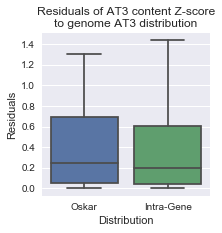

In [32]:
f = plt.figure(figsize=(3,3))
sns.boxplot(data=residuals,x='Distribution',y='Residuals', showfliers=False, order=['Oskar','Intra-Gene'])
plt.title('Residuals of AT3 content Z-score\nto genome AT3 distribution')
f.savefig('AT3_Residuals.png',dpi = 600)
f.savefig('AT3_Residuals.pdf')

26289
('Coefficients: \n', array([[-0.74664179]]))
Residual sum of squares: 0.56
Residual sum of squares Osk: 9.25
Variance score: 0.52


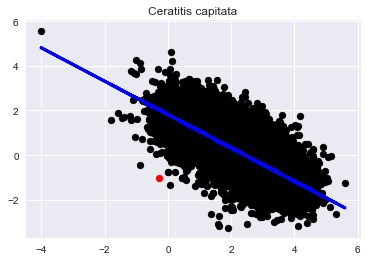

14097
('Coefficients: \n', array([[-0.75418856]]))
Residual sum of squares: 0.37
Residual sum of squares Osk: 1.87
Variance score: 0.67


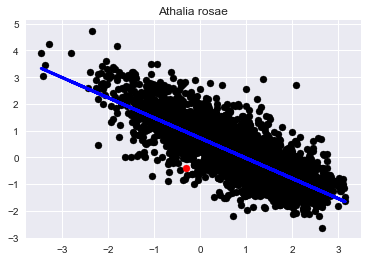

14819
('Coefficients: \n', array([[-0.75170468]]))
Residual sum of squares: 0.43
Residual sum of squares Osk: 4.77
Variance score: 0.60


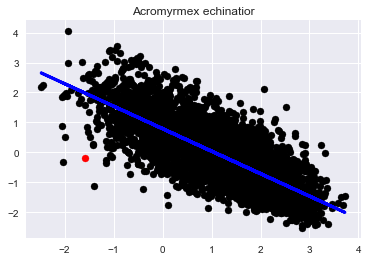

10938
('Coefficients: \n', array([[-0.84723207]]))
Residual sum of squares: 0.35
Residual sum of squares Osk: 0.02
Variance score: 0.70


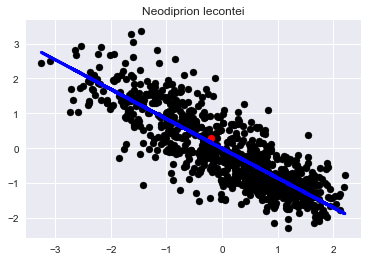

12058
('Coefficients: \n', array([[-0.76853622]]))
Residual sum of squares: 0.55
Residual sum of squares Osk: 7.26
Variance score: 0.52


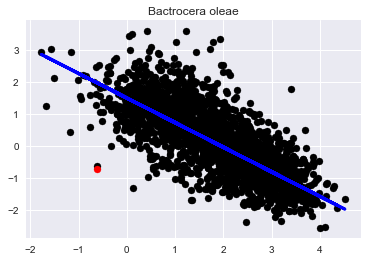

15594
('Coefficients: \n', array([[-0.65536447]]))
Residual sum of squares: 0.80
Residual sum of squares Osk: 10.16
Variance score: 0.36


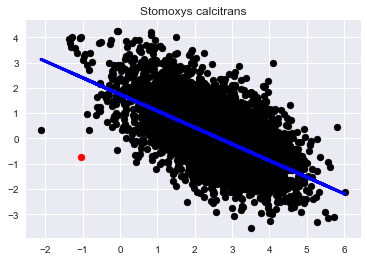

17620
('Coefficients: \n', array([[-0.70248895]]))
Residual sum of squares: 0.69
Residual sum of squares Osk: 5.05
Variance score: 0.43


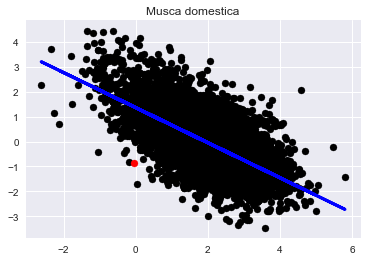

12097
('Coefficients: \n', array([[-0.85649414]]))
Residual sum of squares: 0.31
Residual sum of squares Osk: 0.62
Variance score: 0.73


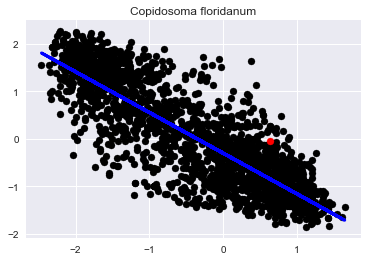

14763
('Coefficients: \n', array([[-0.75499487]]))
Residual sum of squares: 0.48
Residual sum of squares Osk: 5.29
Variance score: 0.66


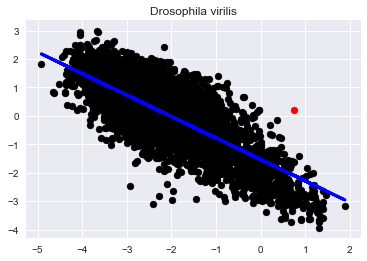

12297
('Coefficients: \n', array([[-0.70262751]]))
Residual sum of squares: 0.51
Residual sum of squares Osk: 1.39
Variance score: 0.46


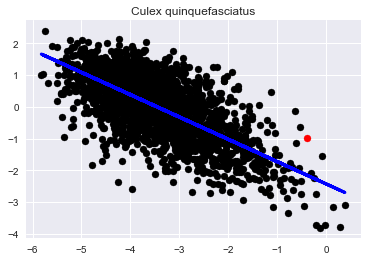

14143
('Coefficients: \n', array([[-0.78473781]]))
Residual sum of squares: 0.34
Residual sum of squares Osk: 6.96
Variance score: 0.70


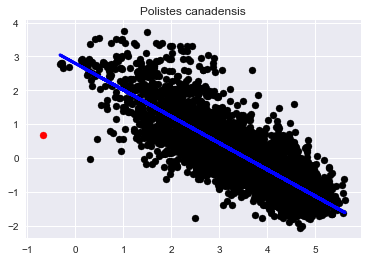

12923
('Coefficients: \n', array([[-0.79054597]]))
Residual sum of squares: 0.40
Residual sum of squares Osk: 7.10
Variance score: 0.64


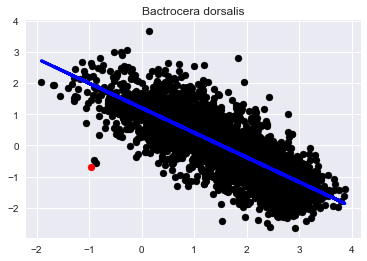

21388
('Coefficients: \n', array([[-0.74256052]]))
Residual sum of squares: 0.50
Residual sum of squares Osk: 2.48
Variance score: 0.54


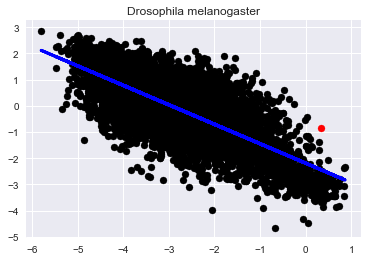

13031
('Coefficients: \n', array([[-0.8378577]]))
Residual sum of squares: 0.30
Residual sum of squares Osk: 2.11
Variance score: 0.71


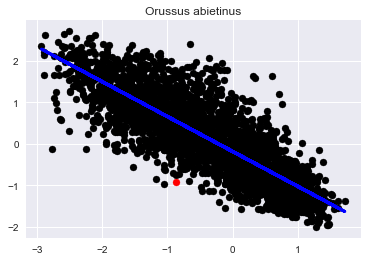

17142
('Coefficients: \n', array([[-0.84312263]]))
Residual sum of squares: 0.31
Residual sum of squares Osk: 0.71
Variance score: 0.70


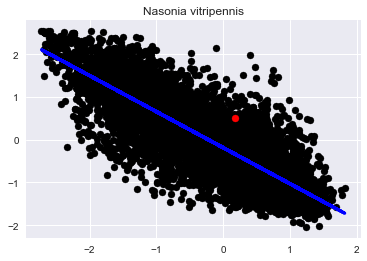

14934
('Coefficients: \n', array([[-0.76928304]]))
Residual sum of squares: 0.29
Residual sum of squares Osk: 0.02
Variance score: 0.72


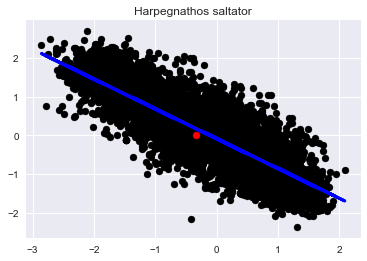

13622
('Coefficients: \n', array([[-0.58333552]]))
Residual sum of squares: 0.70
Residual sum of squares Osk: 1.20
Variance score: 0.28


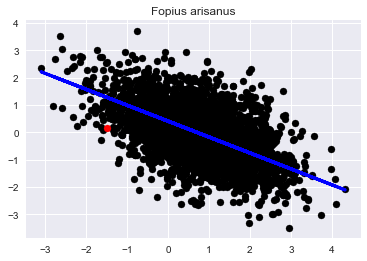

In [33]:
codon = 'GC3'
residuals= []
for orga in LOTUS:
    # Split the data into training/testing sets
    X = null_codon3[(null_codon3['Domain'] == 'D0') & (null_codon3['Organism'] == orga) & (null_codon3['Codon'] == codon)]['Z_score'].values
    print len(X)
    X_train = np.array([X[:10000]]).T
    X_test = np.array([X[10000:]]).T
    X_osk = np.array([signi_GC3_df[(signi_GC3_df['Domain']=='LOTUS') & (signi_GC3_df['Organism']== orga) & (signi_GC3_df['Codon']==codon)]['Z_score'].values]).T
    # Split the targets into training/testing sets
    Y = null_codon3[(null_codon3['Domain'] == 'D1') & (null_codon3['Organism'] == orga) & (null_codon3['Codon'] == codon)]['Z_score'].values
    y_train = np.array([Y[:10000]]).T
    y_test = np.array([Y[10000:]]).T
    y_osk = np.array([signi_GC3_df[(signi_GC3_df['Domain']=='SGNH') & (signi_GC3_df['Organism']== orga) & (signi_GC3_df['Codon']==codon)]['Z_score'].values]).T

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    for i in ((regr.predict(X_test) - y_test) ** 2):
        residuals.append(['Intra-Gene', i[0]])
    print("Residual sum of squares Osk: %.2f"
          % np.mean((regr.predict(X_osk) - y_osk) ** 2))
    residuals.append(['Oskar', np.mean((regr.predict(X_osk) - y_osk) ** 2)])
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))

    # Plot outputs
    plt.scatter(X_test, y_test,  color='black')
    plt.plot(X_test, regr.predict(X_test), color='blue',
             linewidth=3)
    plt.scatter(X_osk, y_osk,  color='red')
    plt.title(orga)
    plt.show()
residuals = pd.DataFrame(residuals, columns=['Distribution', 'Residuals'])

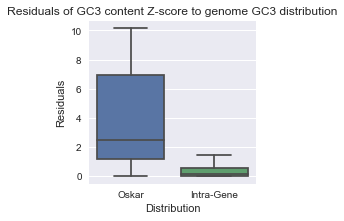

In [34]:
f = plt.figure(figsize=(3,3))
sns.boxplot(data=residuals,x='Distribution',y='Residuals', showfliers=False, order=['Oskar','Intra-Gene'])
plt.title('Residuals of GC3 content Z-score to genome GC3 distribution')
f.savefig('GC3_Residuals.png',dpi = 600)
f.savefig('GC3_Residuals.pdf')

In [35]:
x = residuals[(residuals['Distribution'] == 'Intra-Gene')]['Residuals'].values
y = residuals[(residuals['Distribution'] == 'Oskar')]['Residuals'].values
print codon, sp.stats.mannwhitneyu(x,y)

GC3 MannwhitneyuResult(statistic=215671.0, pvalue=1.9266597162799448e-07)


# 8) Analysis of the residuals of the linear regression of genome A3/T3/G3/C3 content

26289
('Coefficients: \n', array([[ 0.56117587]]))
Residual sum of squares: 0.85
Residual sum of squares Osk: 0.55
Variance score: 0.32


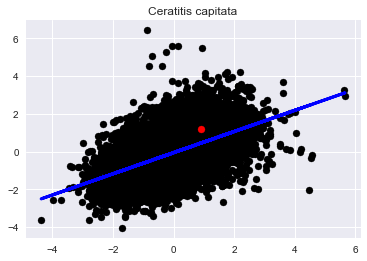

26289
('Coefficients: \n', array([[ 0.42575326]]))
Residual sum of squares: 0.99
Residual sum of squares Osk: 0.19
Variance score: 0.17


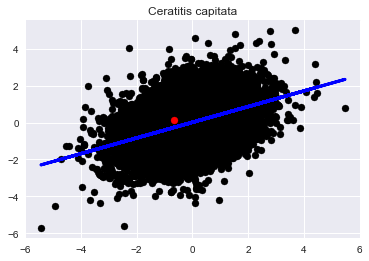

26289
('Coefficients: \n', array([[ 0.49999624]]))
Residual sum of squares: 1.02
Residual sum of squares Osk: 0.61
Variance score: 0.23


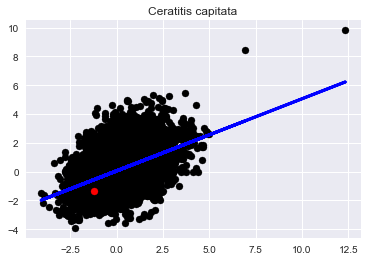

26289
('Coefficients: \n', array([[ 0.56166209]]))
Residual sum of squares: 0.74
Residual sum of squares Osk: 0.48
Variance score: 0.30


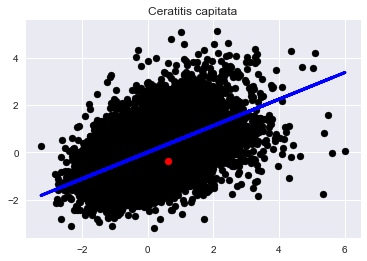

14097
('Coefficients: \n', array([[ 0.63016514]]))
Residual sum of squares: 0.69
Residual sum of squares Osk: 0.28
Variance score: 0.41


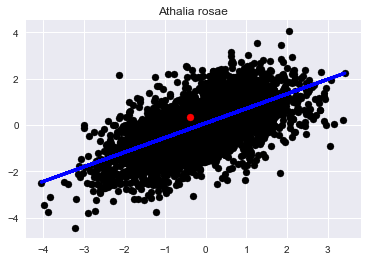

14097
('Coefficients: \n', array([[ 0.60458382]]))
Residual sum of squares: 0.65
Residual sum of squares Osk: 0.05
Variance score: 0.46


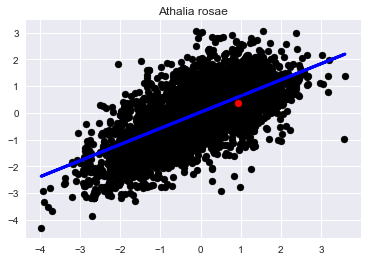

14097
('Coefficients: \n', array([[ 0.52286908]]))
Residual sum of squares: 0.81
Residual sum of squares Osk: 0.04
Variance score: 0.36


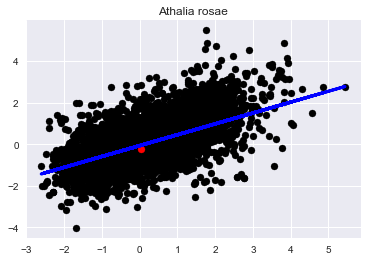

14097
('Coefficients: \n', array([[ 0.69035533]]))
Residual sum of squares: 0.53
Residual sum of squares Osk: 0.01
Variance score: 0.53


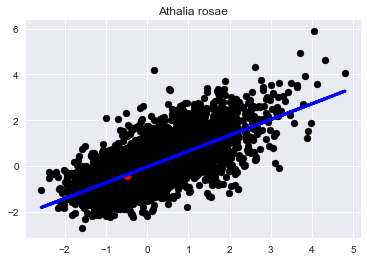

14819
('Coefficients: \n', array([[ 0.66987286]]))
Residual sum of squares: 0.66
Residual sum of squares Osk: 4.99
Variance score: 0.43


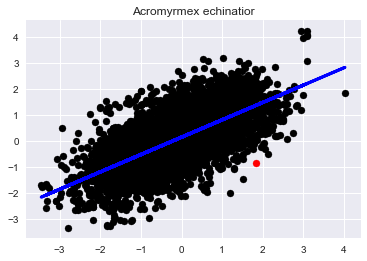

14819
('Coefficients: \n', array([[ 0.61439314]]))
Residual sum of squares: 0.65
Residual sum of squares Osk: 0.59
Variance score: 0.41


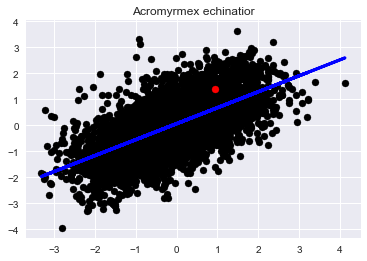

14819
('Coefficients: \n', array([[ 0.61542292]]))
Residual sum of squares: 0.67
Residual sum of squares Osk: 0.16
Variance score: 0.39


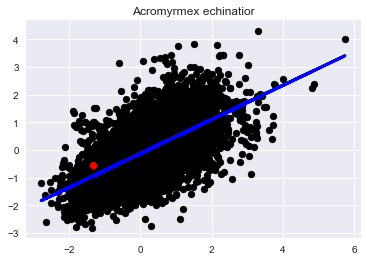

14819
('Coefficients: \n', array([[ 0.69080596]]))
Residual sum of squares: 0.53
Residual sum of squares Osk: 1.53
Variance score: 0.51


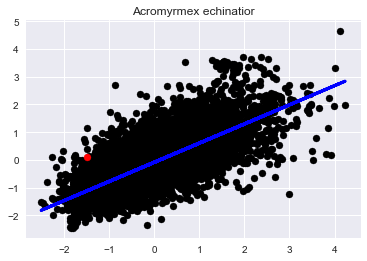

10938
('Coefficients: \n', array([[ 0.7544045]]))
Residual sum of squares: 0.60
Residual sum of squares Osk: 0.30
Variance score: 0.50


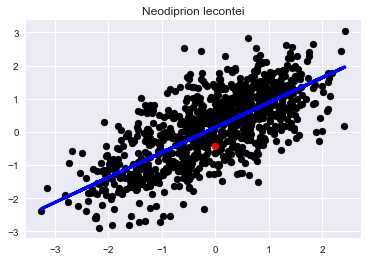

10938
('Coefficients: \n', array([[ 0.68766812]]))
Residual sum of squares: 0.57
Residual sum of squares Osk: 0.25
Variance score: 0.50


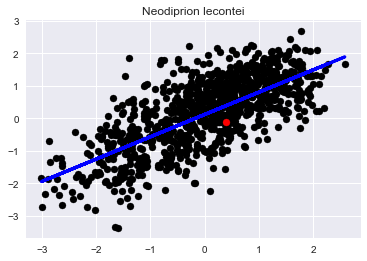

10938
('Coefficients: \n', array([[ 0.59220384]]))
Residual sum of squares: 0.70
Residual sum of squares Osk: 0.00
Variance score: 0.40


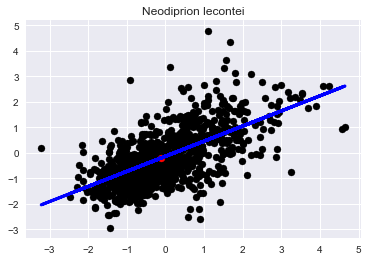

10938
('Coefficients: \n', array([[ 0.7721392]]))
Residual sum of squares: 0.53
Residual sum of squares Osk: 0.76
Variance score: 0.56


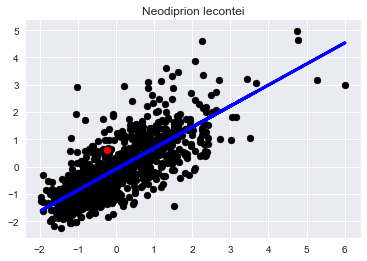

12058
('Coefficients: \n', array([[ 0.5990029]]))
Residual sum of squares: 0.78
Residual sum of squares Osk: 1.12
Variance score: 0.32


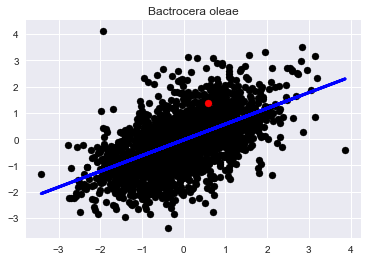

12058
('Coefficients: \n', array([[ 0.51786497]]))
Residual sum of squares: 0.89
Residual sum of squares Osk: 0.36
Variance score: 0.27


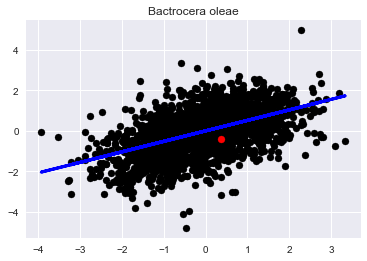

12058
('Coefficients: \n', array([[ 0.54499089]]))
Residual sum of squares: 0.93
Residual sum of squares Osk: 0.00
Variance score: 0.28


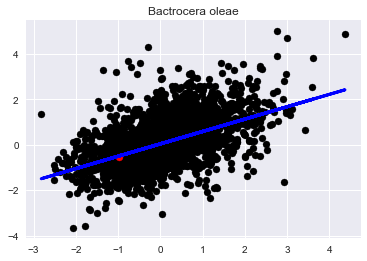

12058
('Coefficients: \n', array([[ 0.61503112]]))
Residual sum of squares: 0.68
Residual sum of squares Osk: 0.30
Variance score: 0.35


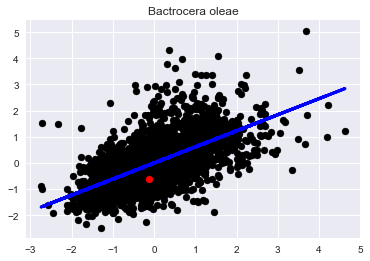

15594
('Coefficients: \n', array([[ 0.54894695]]))
Residual sum of squares: 0.85
Residual sum of squares Osk: 0.12
Variance score: 0.25


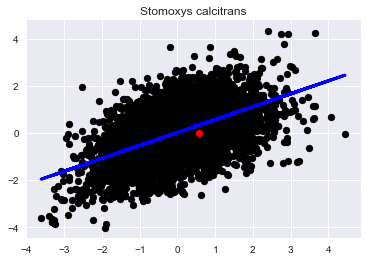

15594
('Coefficients: \n', array([[ 0.41400996]]))
Residual sum of squares: 1.07
Residual sum of squares Osk: 0.51
Variance score: 0.14


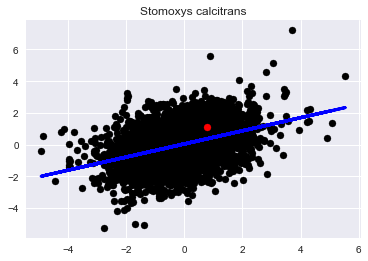

15594
('Coefficients: \n', array([[ 0.38242784]]))
Residual sum of squares: 1.08
Residual sum of squares Osk: 0.65
Variance score: 0.12


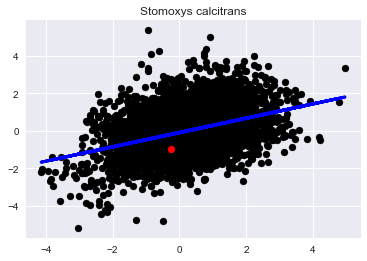

15594
('Coefficients: \n', array([[ 0.59857044]]))
Residual sum of squares: 0.83
Residual sum of squares Osk: 0.20
Variance score: 0.28


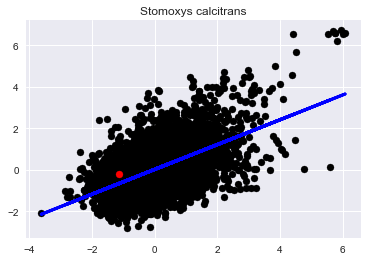

17620
('Coefficients: \n', array([[ 0.59462385]]))
Residual sum of squares: 0.79
Residual sum of squares Osk: 0.30
Variance score: 0.34


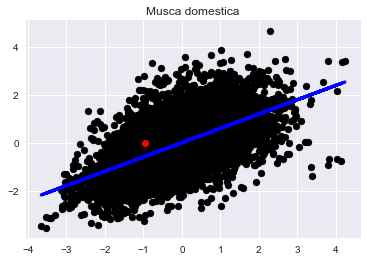

17620
('Coefficients: \n', array([[ 0.44866187]]))
Residual sum of squares: 0.97
Residual sum of squares Osk: 0.33
Variance score: 0.20


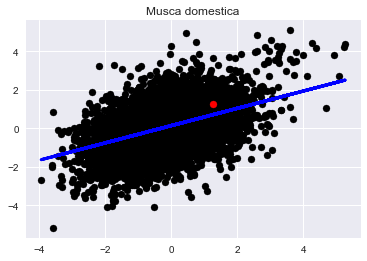

17620
('Coefficients: \n', array([[ 0.43452946]]))
Residual sum of squares: 1.02
Residual sum of squares Osk: 1.07
Variance score: 0.19


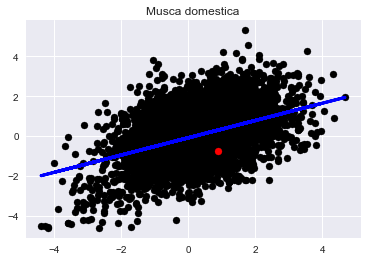

17620
('Coefficients: \n', array([[ 0.62907132]]))
Residual sum of squares: 0.71
Residual sum of squares Osk: 0.00
Variance score: 0.35


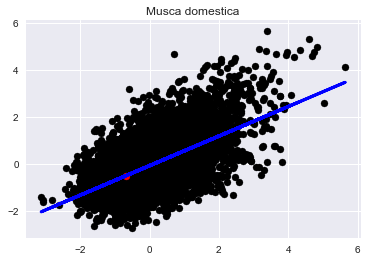

12097
('Coefficients: \n', array([[ 0.82075852]]))
Residual sum of squares: 0.48
Residual sum of squares Osk: 0.04
Variance score: 0.60


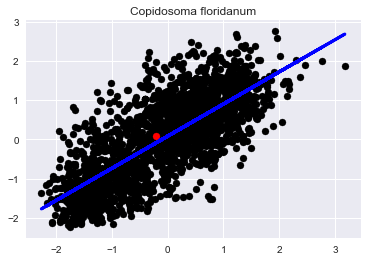

12097
('Coefficients: \n', array([[ 0.77700741]]))
Residual sum of squares: 0.36
Residual sum of squares Osk: 0.47
Variance score: 0.67


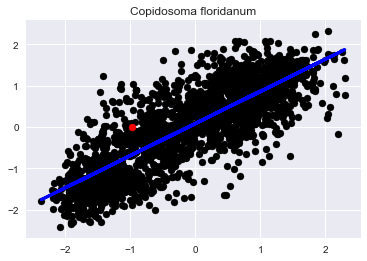

12097
('Coefficients: \n', array([[ 0.75327637]]))
Residual sum of squares: 0.55
Residual sum of squares Osk: 0.00
Variance score: 0.54


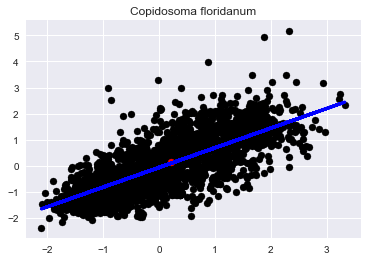

12097
('Coefficients: \n', array([[ 0.79525142]]))
Residual sum of squares: 0.42
Residual sum of squares Osk: 0.64
Variance score: 0.63


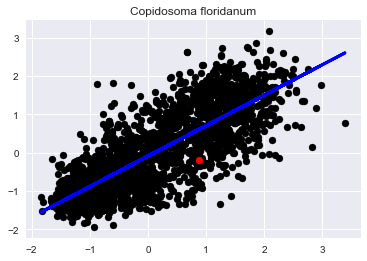

14763
('Coefficients: \n', array([[ 0.60315835]]))
Residual sum of squares: 0.64
Residual sum of squares Osk: 0.11
Variance score: 0.51


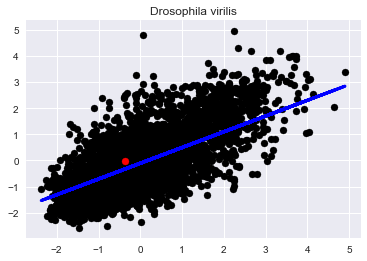

14763
('Coefficients: \n', array([[ 0.61123815]]))
Residual sum of squares: 0.77
Residual sum of squares Osk: 0.03
Variance score: 0.44


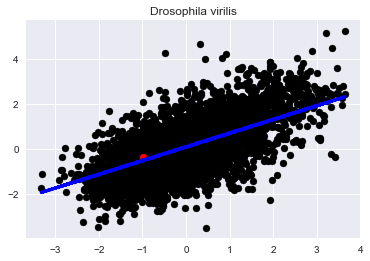

14763
('Coefficients: \n', array([[ 0.53521146]]))
Residual sum of squares: 0.84
Residual sum of squares Osk: 0.57
Variance score: 0.38


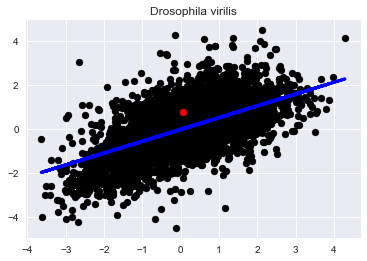

14763
('Coefficients: \n', array([[ 0.58406681]]))
Residual sum of squares: 0.89
Residual sum of squares Osk: 1.32
Variance score: 0.37


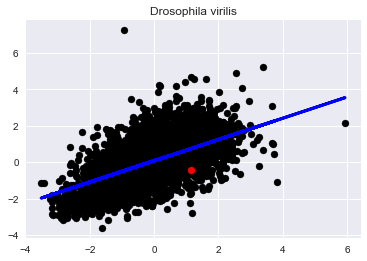

12297
('Coefficients: \n', array([[ 0.57650844]]))
Residual sum of squares: 0.64
Residual sum of squares Osk: 0.73
Variance score: 0.31


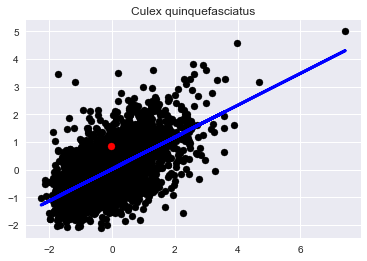

12297
('Coefficients: \n', array([[ 0.61702944]]))
Residual sum of squares: 0.66
Residual sum of squares Osk: 0.33
Variance score: 0.33


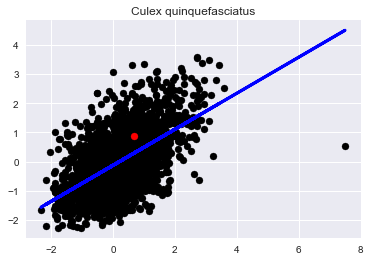

12297
('Coefficients: \n', array([[ 0.3853477]]))
Residual sum of squares: 0.91
Residual sum of squares Osk: 2.10
Variance score: 0.18


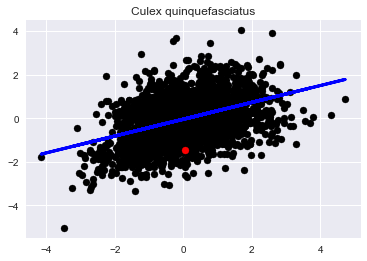

12297
('Coefficients: \n', array([[ 0.41545777]]))
Residual sum of squares: 1.07
Residual sum of squares Osk: 0.01
Variance score: 0.13


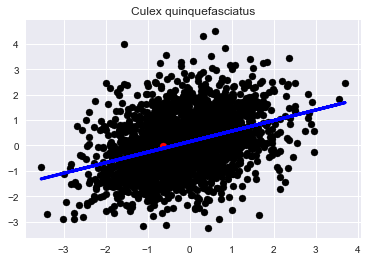

14143
('Coefficients: \n', array([[ 0.62911756]]))
Residual sum of squares: 0.65
Residual sum of squares Osk: 5.76
Variance score: 0.46


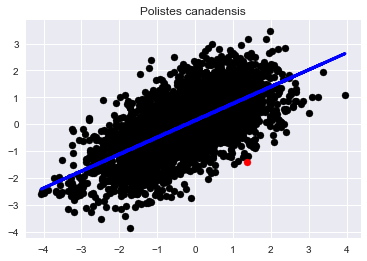

14143
('Coefficients: \n', array([[ 0.57902539]]))
Residual sum of squares: 0.77
Residual sum of squares Osk: 0.23
Variance score: 0.35


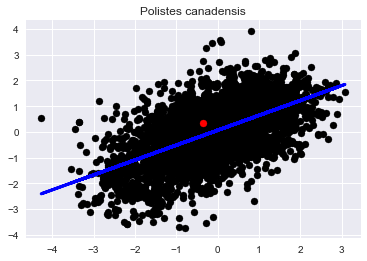

14143
('Coefficients: \n', array([[ 0.60980589]]))
Residual sum of squares: 0.63
Residual sum of squares Osk: 1.75
Variance score: 0.43


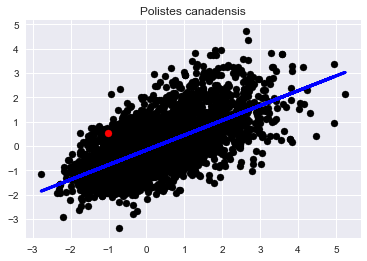

14143
('Coefficients: \n', array([[ 0.73335118]]))
Residual sum of squares: 0.50
Residual sum of squares Osk: 0.99
Variance score: 0.59


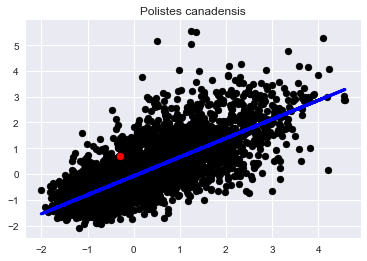

12923
('Coefficients: \n', array([[ 0.63918035]]))
Residual sum of squares: 0.74
Residual sum of squares Osk: 0.62
Variance score: 0.36


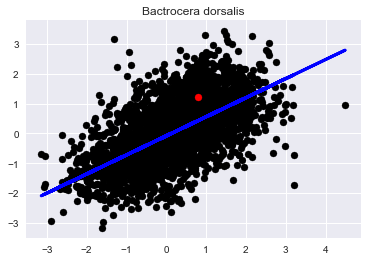

12923
('Coefficients: \n', array([[ 0.5717317]]))
Residual sum of squares: 0.87
Residual sum of squares Osk: 0.32
Variance score: 0.34


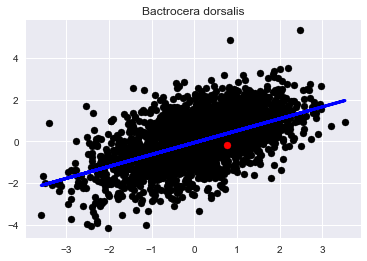

12923
('Coefficients: \n', array([[ 0.58064785]]))
Residual sum of squares: 0.86
Residual sum of squares Osk: 0.01
Variance score: 0.34


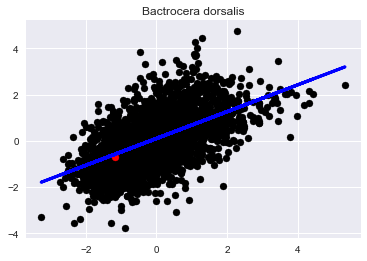

12923
('Coefficients: \n', array([[ 0.66322333]]))
Residual sum of squares: 0.56
Residual sum of squares Osk: 0.05
Variance score: 0.44


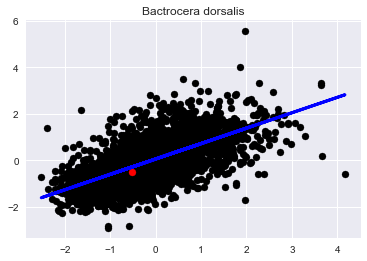

21388
('Coefficients: \n', array([[ 0.64268671]]))
Residual sum of squares: 0.66
Residual sum of squares Osk: 1.38
Variance score: 0.41


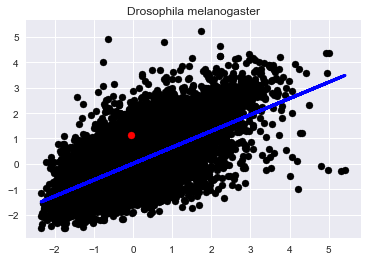

21388
('Coefficients: \n', array([[ 0.62836638]]))
Residual sum of squares: 0.63
Residual sum of squares Osk: 0.41
Variance score: 0.41


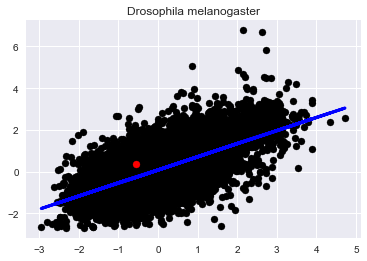

21388
('Coefficients: \n', array([[ 0.49923394]]))
Residual sum of squares: 0.85
Residual sum of squares Osk: 1.35
Variance score: 0.27


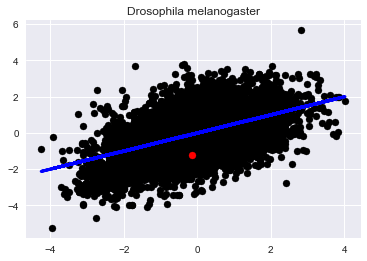

21388
('Coefficients: \n', array([[ 0.62443095]]))
Residual sum of squares: 0.66
Residual sum of squares Osk: 0.33
Variance score: 0.39


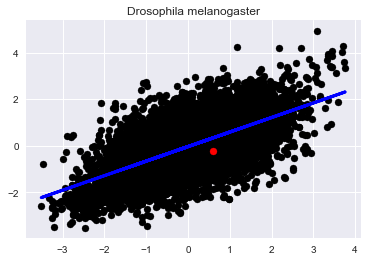

13031
('Coefficients: \n', array([[ 0.8084369]]))
Residual sum of squares: 0.44
Residual sum of squares Osk: 0.02
Variance score: 0.60


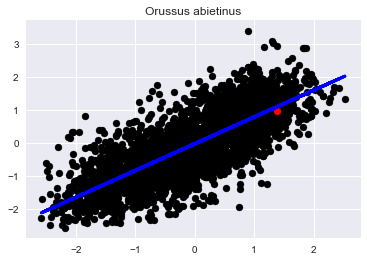

13031
('Coefficients: \n', array([[ 0.74302637]]))
Residual sum of squares: 0.43
Residual sum of squares Osk: 0.41
Variance score: 0.59


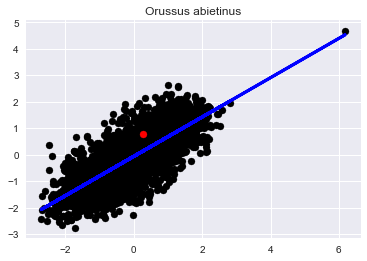

13031
('Coefficients: \n', array([[ 0.71349077]]))
Residual sum of squares: 0.52
Residual sum of squares Osk: 0.50
Variance score: 0.51


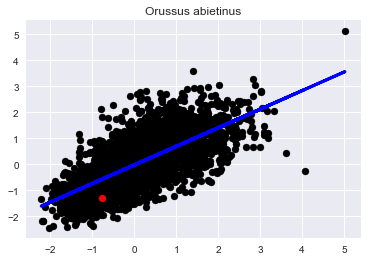

13031
('Coefficients: \n', array([[ 0.79621523]]))
Residual sum of squares: 0.42
Residual sum of squares Osk: 0.00
Variance score: 0.60


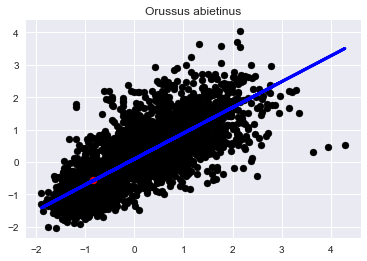

17142
('Coefficients: \n', array([[ 0.79078513]]))
Residual sum of squares: 0.41
Residual sum of squares Osk: 0.37
Variance score: 0.60


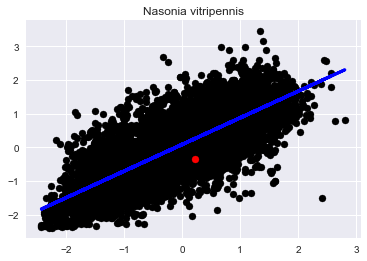

17142
('Coefficients: \n', array([[ 0.79358056]]))
Residual sum of squares: 0.41
Residual sum of squares Osk: 0.05
Variance score: 0.61


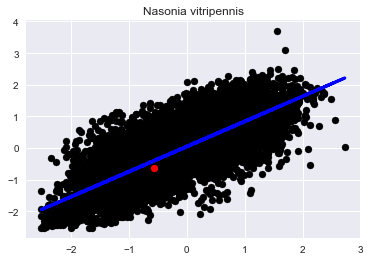

17142
('Coefficients: \n', array([[ 0.69825271]]))
Residual sum of squares: 0.56
Residual sum of squares Osk: 0.58
Variance score: 0.47


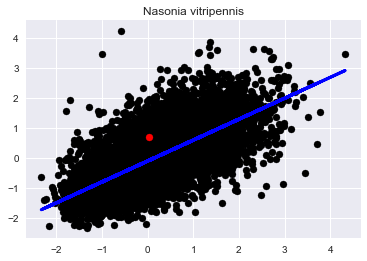

17142
('Coefficients: \n', array([[ 0.83298223]]))
Residual sum of squares: 0.38
Residual sum of squares Osk: 0.03
Variance score: 0.64


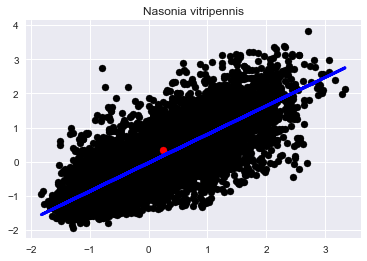

14934
('Coefficients: \n', array([[ 0.73005661]]))
Residual sum of squares: 0.40
Residual sum of squares Osk: 0.74
Variance score: 0.61


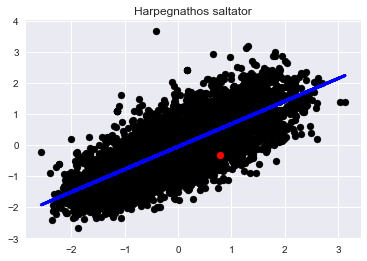

14934
('Coefficients: \n', array([[ 0.69011572]]))
Residual sum of squares: 0.42
Residual sum of squares Osk: 0.34
Variance score: 0.61


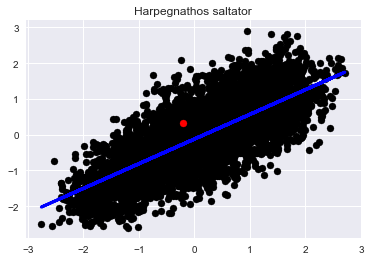

14934
('Coefficients: \n', array([[ 0.67025723]]))
Residual sum of squares: 0.51
Residual sum of squares Osk: 0.99
Variance score: 0.53


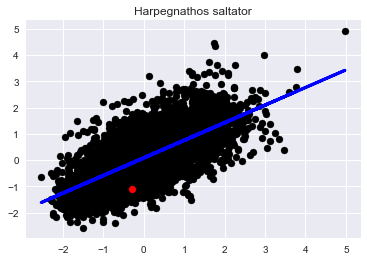

14934
('Coefficients: \n', array([[ 0.72170408]]))
Residual sum of squares: 0.39
Residual sum of squares Osk: 1.21
Variance score: 0.63


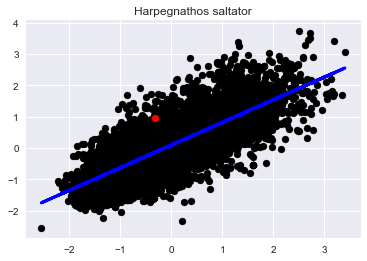

13622
('Coefficients: \n', array([[ 0.46789553]]))
Residual sum of squares: 1.04
Residual sum of squares Osk: 0.67
Variance score: 0.13


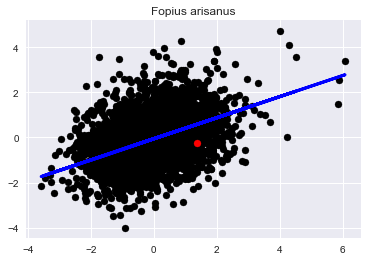

13622
('Coefficients: \n', array([[ 0.33358908]]))
Residual sum of squares: 1.11
Residual sum of squares Osk: 0.27
Variance score: 0.08


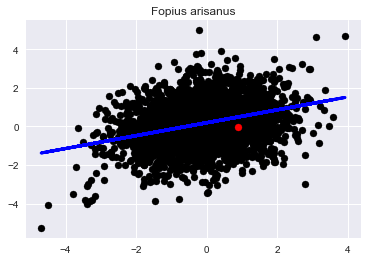

13622
('Coefficients: \n', array([[ 0.40205375]]))
Residual sum of squares: 1.12
Residual sum of squares Osk: 0.31
Variance score: 0.14


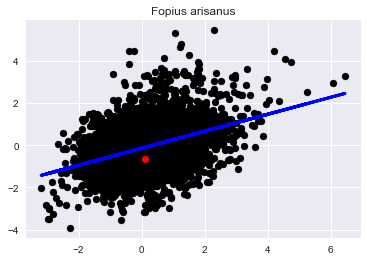

13622
('Coefficients: \n', array([[ 0.42603515]]))
Residual sum of squares: 0.98
Residual sum of squares Osk: 3.15
Variance score: 0.14


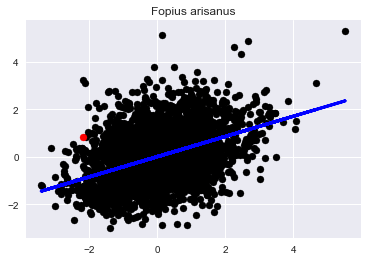

In [36]:
residuals_atgc3 = []
for orga in LOTUS:
    for codon in ['A3','T3','C3','G3']:
        # Split the data into training/testing sets
        X = null_at3gc3[(null_at3gc3['Domain'] == 'D0') & (null_at3gc3['Organism'] == orga) & (null_at3gc3['Codon'] == codon)]['Z_score'].values
        print len(X)
        X_train = np.array([X[:10000]]).T
        X_test = np.array([X[10000:]]).T
        X_osk = np.array([signi_3_df[(signi_3_df['Domain']=='LOTUS') & (signi_3_df['Organism']== orga) & (signi_3_df['Codon']==codon)]['Z_score'].values]).T
        # Split the targets into training/testing sets
        Y = null_at3gc3[(null_at3gc3['Domain'] == 'D1') & (null_at3gc3['Organism'] == orga) & (null_at3gc3['Codon'] == codon)]['Z_score'].values
        y_train = np.array([Y[:10000]]).T
        y_test = np.array([Y[10000:]]).T
        y_osk = np.array([signi_3_df[(signi_3_df['Domain']=='SGNH') & (signi_3_df['Organism']== orga) & (signi_3_df['Codon']==codon)]['Z_score'].values]).T

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean square error
        print("Residual sum of squares: %.2f"
              % np.mean((regr.predict(X_test) - y_test) ** 2))
        for i in ((regr.predict(X_test) - y_test) ** 2):
            residuals_atgc3.append(['Intra-Gene', codon, i[0]])
        print("Residual sum of squares Osk: %.2f"
              % np.mean((regr.predict(X_osk) - y_osk) ** 2))
        residuals_atgc3.append(['Oskar', codon, np.mean((regr.predict(X_osk) - y_osk) ** 2)])
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regr.score(X_test, y_test))

        # Plot outputs
        plt.scatter(X_test, y_test,  color='black')
        plt.plot(X_test, regr.predict(X_test), color='blue',
                 linewidth=3)
        plt.scatter(X_osk, y_osk,  color='red')
        plt.title(orga)
        plt.show()
residuals_atgc3 = pd.DataFrame(residuals_atgc3, columns=['Distribution', 'Codon', 'Residuals'])

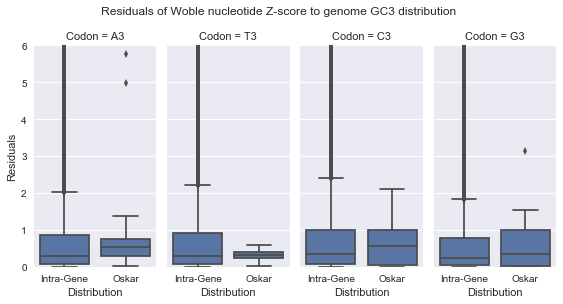

In [37]:
f = plt.figure()
g = sns.FacetGrid(residuals_atgc3, col="Codon", size=4, aspect=.5)
g = g.map(sns.boxplot, "Distribution", "Residuals")
plt.suptitle('Residuals of Woble nucleotide Z-score to genome GC3 distribution',y=1.05)
plt.ylim(0,6)
g.savefig('wobble_Residuals.png',dpi = 600)

In [38]:
for codon in ['A3','T3','C3','G3']:
    x = residuals_atgc3[(residuals_atgc3['Distribution'] == 'Intra-Gene') & (residuals_atgc3['Codon'] == codon)]['Residuals'].values
    y = residuals_atgc3[(residuals_atgc3['Distribution'] == 'Oskar') & (residuals_atgc3['Codon'] == codon)]['Residuals'].values
    print codon, sp.stats.mannwhitneyu(x,y)

A3 MannwhitneyuResult(statistic=601131.0, pvalue=0.082867071020995609)
T3 MannwhitneyuResult(statistic=704170.0, pvalue=0.34470878531693128)
C3 MannwhitneyuResult(statistic=737459.0, pvalue=0.46773340223556231)
G3 MannwhitneyuResult(statistic=730796.0, pvalue=0.4424525911654042)
